# Example for system in Meyers, Craig and Odde 2006

This model geometry consists of 2 domains - one surface and one volume:
- plasma membrane (PM) - cell surface
- cytosol - intracellular volume

In this case, we only model the case of a spherical cell, where the cytosol corresponds to the interior of the sphere and the PM corresponds to the surface of the sphere.

This model includes a single species, A, which is phosphorylated at the cell membrane. The unphosphorylated form of A ($A_{dephos}$) can be computed from mass conservation; everywhere $c_{A_{phos}} + c_{A_{dephos}} = c_{Tot}$, which is a constant in both time and space if the phosphorylated vs. unphosphorylated forms have the same diffusion coefficient.

There are two reactions - one in the PM and other in the cytosol. At the membrane, $A_{dephos}$ is phosphorylated by a first-order reaction with rate $k_{kin}$, and in the cytosolic volume, $A_{phos}$ is dephosphorylated by a first order reaction with rate $k_p$.


In [1]:
import os
import logging

import dolfin as d
import numpy as np
import sympy as sym

from smart import config, common, mesh, model
from smart.model_assembly import (
    Compartment,
    Parameter,
    Reaction,
    Species,
    SpeciesContainer,
    ParameterContainer,
    CompartmentContainer,
    ReactionContainer,
)
from smart.units import unit

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'


We will set the logging level to `INFO`. This will display some output during the simulation. If you want to get even more output you could set the logging level to `DEBUG`.

In [2]:
logger = logging.getLogger("smart")
logger.setLevel(logging.WARNING)

Futhermore, you could also save the logs to a file by attaching a file handler to the logger as follows.

```python
file_handler = logging.FileHandler("filename.log")
file_handler.setFormatter(logging.Formatter(smart.config.base_format))
logger.addHandler(file_handler)
```

Now, we define various units used in this problem.

In [3]:
# Aliases - base units
uM = unit.uM
um = unit.um
molecule = unit.molecule
sec = unit.sec
dimensionless = unit.dimensionless
# Aliases - units used in model
D_unit = um**2 / sec
flux_unit = molecule / (um**2 * sec)
vol_unit = uM

## Generate model
Next we generate the model, which consists of four containers - compartments, species, reactions, and parameters.

### Compartments
As described above, the two compartments are the cytosol ("Cyto") and the plasma membrane ("PM"). These are initialized by calling:
```python
compartment_name = Compartment(name, dim, units, marker)
```
where
- name = string naming the compartment (should match variable name "compartment_name")
- dim = topological dimensionality (i.e. 3 for Cyto, 2 for PM)
- units = length units for the compartment (um for both here)
- marker = marker value identifying each compartment in the parent mesh

In [4]:
Cyto = Compartment("Cyto", 3, um, 1)
PM = Compartment("PM", 2, um, 10)

Create a compartment container.

In [5]:
cc = CompartmentContainer()
cc.add([PM, Cyto])

### Species
In this case, we have a single species, "A", which exists in the cytosol. A single species is initialized by calling:
```python
species_name = Species(name, conc_init, conc_units, D, D_units, compartment)
```
where
- name = string naming the species (should match variable name "species_name")
- conc_init = initial concentration for this species (can be an expression given by a string to be parsed by sympy - the only unknowns in the expression should be x, y, and z)
- conc_units = concentration units for this species (micromolar/uM here)
- D = diffusion coefficient
- D_units = units for diffusion coefficient (um**2/sec here)
- compartment = each species should be assigned to a single compartment ("Cyto", here)

In [6]:
Aphos = Species("Aphos", 0.1, vol_unit, 10.0, D_unit, "Cyto")

Create a species container.

In [7]:
sc = SpeciesContainer()
sc.add([Aphos])

### Parameters and Reactions
Parameters and reactions are generally defined together, although the order does not strictly matter. Parameters are specified as:
```python
param_name = Parameter(name, value, units, group (opt))
```
where
- name: string naming the parameter (should match variable name "param_name")
- value: value of the given parameter
- units: units associated with given value
- group: optional string placing this reaction in a reaction group; for organizational purposes when there are multiple reaction modules

Reactions are specified by a variable number of arguments (optional arguments are indicated by (opt) here):
```python
reaction_name = Reaction(name, reactants, products, param_map
                         eqn_f_str (opt), eqn_r_str (opt), reaction_type (opt), species_map (opt), 
                         explicit_restriction_to_domain (opt), group (opt), flux_scaling (opt))
```
required arguments:
- name: string naming the parameter (should match variable name "param_name")
- reactants: list of strings specifying the reactants for this reaction
- products: list of strings specifying the products for this reaction
    ***NOTE: the lists "reactants" and "products" determine the stoichiometry of the reaction,
       for instance, if two A's react to give one B, the reactants list would be ["A","A"],
       and the products list would be ["B"]
- param_map: relationship between the parameters specified in the reaction string and those given
              in the parameter container. By default, the reaction parameters are "kon" and "koff" when
              a system obeys simple mass action. If the forward rate is given by a parameter "k1" and the
              reverse rate is given by "k2", then param_map = {"kon":"k1", "koff":"k2"}

optional arguments:
- eqn_f_str: For systems not obeying simple mass action, this string specifies the forward reaction rate
             By default, this string is "kon*{all reactants multiplied together}"
- eqn_r_str: For systems not obeying simple mass action, this string specifies the reverse reaction rate
             By default, this string is "koff*{all products multiplied together}"
- reaction_type: either "custom" or "mass_action" (default is "mass_action") [never a required argument]
- species_map: same format as param_map; only required if the species name in the reaction string do not
               match the species names given in the species container
- explicit_restriction_to_domain: string specifying where the reaction occurs; required if the reaction is not
                                  constrained by the reaction string (e.g., if production occurs only at the boundary,
                                  as it does here, but the species being produced exists through the entire volume)
- group: string placing this reaction in a reaction group; for organizational purposes when there are multiple reaction modules
- flux_scaling: in certain cases, a given reactant or product may experience a scaled flux (for instance, if we assume that
                some of the molecules are immediately sequestered after the reaction); in this case, to signify that this flux 
                should be rescaled, we specify ''flux_scaling = {scaled_species: scale_factor}'', where scaled_species is a
                string specifying the species to be scaled and scale_factor is a number specifying the rescaling factor

In [8]:
Atot = Parameter("Atot", 1.0, vol_unit)
# Phosphorylation of Adephos at the PM
kkin = Parameter("kkin", 50.0, 1/sec)
curRadius = 1 # first radius value to test 
VolSA = Parameter("VolSA", curRadius/3, um) # vol to surface area ratio of the cell (overwritten for each cell size)
r1 = Reaction("r1", [], ["Aphos"], param_map={"kon": "kkin", "Atot": "Atot", "VolSA": "VolSA"},
    eqn_f_str="kon*VolSA*(Atot - Aphos)", species_map={"Aphos": "Aphos"}, explicit_restriction_to_domain="PM")
# Dephosphorylation of Aphos in the cytosol
kp = Parameter("kp", 10.0, 1/sec)
r2 = Reaction("r2", ["Aphos"], [], param_map={"kon": "kp"},
        eqn_f_str="kp*Aphos")#, species_map={"Aphos": "Aphos"})

Create parameter and reaction containers.

In [9]:
pc = ParameterContainer()
pc.add([Atot, kkin, VolSA, kp])

rc = ReactionContainer()
rc.add([r1, r2])

We load the model generated above, and load in the mesh we will use in this example.


## Create/load in mesh

In SMART we have different levels of meshes. Here, for our first mesh, we specify a sphere of radius 1.

$$
\Omega: r \in [0, 1] \subset \mathbb{R}^3\\
\text{where} \qquad r = \sqrt{x^2 + y^2 + z^2}
$$

which will serve as our parent mesh, giving the overall cell geometry.

Different domains can be specified within this parent mesh by assigning marker values to cells (3D) or facets (2D) within the mesh. A subdomain within the parent mesh, defined by a region which shares the same marker value, is referred to as a child mesh.

Here, we have two child meshes corresponding to the 2 compartments specified in the compartment container. As defined above, "PM" is a 2D compartment defined by facets with marker value 10 and "Cyto" is a 3D compartment defined by cells with marker value 1. These subdomains are defined by:
- $\Omega_{Cyto}: r \in [0, 1) \subset \mathbb{R}^3$
- $\Gamma_{PM}: r=1 \subset \mathbb{R}^3$

We generate the parent mesh with appropriate markers using gmsh in the function "DemoSpheresMesh"

Info    : Meshing 1D...
Info    : [ 40%] Meshing curve 2 (Circle)
Info    : Done meshing 1D (Wall 0.00651283s, CPU 0.00744s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Sphere, Delaunay)
Info    : Done meshing 2D (Wall 0.0453516s, CPU 0.037848s)
Info    : Meshing 3D...
Info    : 3D Meshing 1 volume with 1 connected component
Info    : Tetrahedrizing 411 nodes...
Info    : Done tetrahedrizing 419 nodes (Wall 0.00559677s, CPU 0s)
Info    : Reconstructing mesh...
Info    :  - Creating surface mesh
Info    :  - Identifying boundary edges
Info    :  - Recovering boundary
Info    : Done reconstructing mesh (Wall 0.0141983s, CPU 0.006635s)
Info    : Found volume 1
Info    : It. 0 - 0 nodes created - worst tet radius 5.6165 (nodes removed 0 0)
Info    : 3D refinement terminated (643 nodes total):
Info    :  - 1 Delaunay cavities modified for star shapeness
Info    :  - 0 nodes could not be inserted
Info    :  - 2618 tetrahedra created in 0.0263809 sec. (99238 tets/s)
Info    : Done me

(-0.5, 1126.5, 738.5, -0.5)

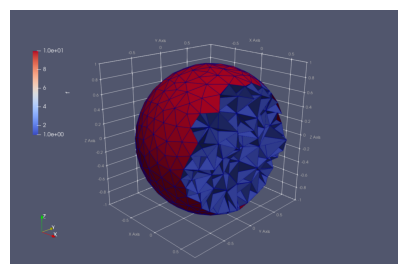

In [10]:
# Base mesh
domain, facet_markers, cell_markers = common.DemoSpheresMesh(curRadius, 0, hEdge = 0.2) # 0 in second argument corresponds to no inner sphere
# ideally want to visualize mesh here using k3d-jupyter, for now just load screenshot
%matplotlib inline
rcParams['figure.figsize'] = 5, 5
# read image from Fig 3b of paper
img_A = mpimg.imread('example2mesh.png')
# fig, ax = plt.subplots(1,2)
plt.imshow(img_A)
plt.axis('off')

In order to load this into a `ParentMesh` object, we need to first save it and then load it in using the smart.mesh.ParentMesh() function

In [11]:
# Write mesh and meshfunctions to file
os.makedirs(f"mesh_{curRadius:03f}", exist_ok=True)
common.write_mesh(domain, facet_markers, cell_markers, filename=f"mesh_{curRadius:03f}/DemoSphere")
# # Define parent mesh
parent_mesh = mesh.ParentMesh(
    mesh_filename=f"mesh_{curRadius:03f}/DemoSphere.h5",
    mesh_filetype="hdf5",
    name="parent_mesh",
)

 2023-05-15 23:42:34,141 smart.mesh - INFO - HDF5 mesh, "parent_mesh", successfully loaded from file: mesh_1.000000/DemoSphere.h5! (mesh.py:205) 


Now we load in the model with the default configuration, then modify the solver configuration for this problem. In the solver config, we set the final t as 1 s, the initial dt at .01 s (without any additional specifications, this will be the time step for the whole simulation), and the time precision (number of digits after the decimal point to round to) as 6. We indicate we are using the SNES solver within PETSc (only option right now) and suppress printing the assembly of the linear system.

In [12]:
configCur = config.Config()
modelCur = model.Model(pc, sc, cc, rc, configCur, parent_mesh)
configCur.solver.update(
    {
        "final_t": 1,
        "initial_dt": 0.01,
        "time_precision": 6,
        "use_snes": True,
        "print_assembly": False,
    }
)

Now we initialize the model and solver. 

In [13]:
modelCur.initialize(initialize_solver=False)
modelCur.initialize_discrete_variational_problem_and_solver()

/usr/lib/python3/dist-packages/pandas/core/dtypes/cast.py:1542: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
/usr/lib/python3/dist-packages/pandas/core/dtypes/cast.py:1542: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
/usr/lib/python3/dist-packages/pandas/core/dtypes/cast.py:1542: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
/usr/lib/python3/dist-packages/pandas/core/dtypes/cast.py:1542: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
 2023-05-15 23:42:34,782 smart.model_assembly - INFO - ╒═══════╤══════════════╤═════════════════════╤════════════╤═════════╤═════════╕
│       │ quantity     │ is_time_dependent   │ sym_expr   │ notes   │ group   │
╞═══════╪══════════════╪═════════════════════╪════════════╪═════════╪═════════╡
│ Atot  │ 1.00×10

╒════╤═════════════╤══════╤══════════════════╤═════════════╤══════════════╤════════════════╕
│    │ name        │   id │   dimensionality │   num_cells │   num_facets │   num_vertices │
╞════╪═════════════╪══════╪══════════════════╪═════════════╪══════════════╪════════════════╡
│  0 │ parent_mesh │   16 │                3 │        2554 │         5517 │            643 │
├────┼─────────────┼──────┼──────────────────┼─────────────┼──────────────┼────────────────┤
│  1 │ PM          │   30 │                2 │         818 │            0 │            411 │
├────┼─────────────┼──────┼──────────────────┼─────────────┼──────────────┼────────────────┤
│  2 │ Cyto        │   36 │                3 │        2554 │         5517 │            643 │
╘════╧═════════════╧══════╧══════════════════╧═════════════╧══════════════╧════════════════╛


We create some XDMF files where we will store the output 

In [14]:
# Write initial condition(s) to file
results = dict()
os.makedirs(f"resultsSphere_{curRadius:03f}", exist_ok=True)
for species_name, species in modelCur.sc.items:
    results[species_name] = d.XDMFFile(
        modelCur.mpi_comm_world, f"resultsSphere_{curRadius:03f}/{species_name}.xdmf"
    )
    results[species_name].parameters["flush_output"] = True
    results[species_name].write(modelCur.sc[species_name].u["u"], modelCur.t)

We now run the solver until t reaches final_t, recording the average Aphos concentration at each time point

In [15]:
# Solve
avg_Aphos = []
tvec = []
while True:
    # Solve the system
    modelCur.monolithic_solve()
    # Save results for post processing
    for species_name, species in modelCur.sc.items:
        results[species_name].write(modelCur.sc[species_name].u["u"], modelCur.t)
    # compute average Aphos concentration at each time step
    dx = d.Measure("dx",domain = modelCur.cc['Cyto'].dolfin_mesh)
    int_val = d.assemble(modelCur.sc['Aphos'].u['u']*dx)
    volume = d.assemble(1.0*dx)
    avg_Aphos.append(int_val / volume)
    tvec.append(modelCur.t)
    # End if we've passed the final time
    if modelCur.t >= modelCur.final_t:
        break



...........................................................................................................................
...........................................................................................................................
..... 2023-05-15 23:42:35,290 smart.model - INFO - Beginning time-step 1 [time=0.010000, dt=0.010000] (model.py:1522) .....
...........................................................................................................................
...........................................................................................................................


 2023-05-15 23:42:35,293 smart.model - INFO - Solving using PETSc.SNES Solver (model.py:1531) 


...........................................................................................................................
..... 2023-05-15 23:42:35,381 smart.model - INFO - Completed time-step 1 [time=0.010000, dt=0.010000] (model.py:1538) .....
...............................

We plot the average Aphos over time.

Text(0, 0.5, 'Aphos concentration (μM)')

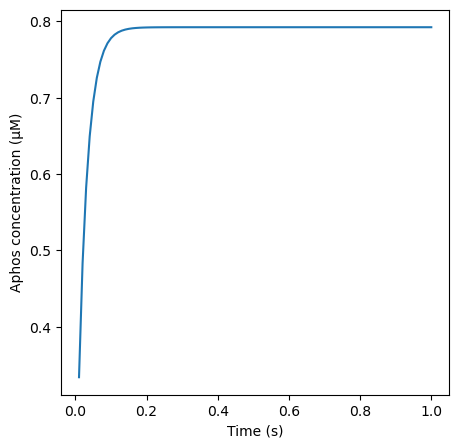

In [16]:
plt.plot(tvec, avg_Aphos)
plt.xlabel('Time (s)')
plt.ylabel('Aphos concentration (μM)')

Now we repeat this process for other values of cell radii, to test the dependence of steady state calcium concentration on cell size

Info    : Meshing 1D...
Info    : [ 40%] Meshing curve 2 (Circle)
Info    : Done meshing 1D (Wall 0.0115026s, CPU 0.01343s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Sphere, Delaunay)
Info    : Meshing surface 1 (Sphere, MeshAdapt)
Info    : Done meshing 2D (Wall 9.31559s, CPU 9.31628s)
Info    : Meshing 3D...
Info    : 3D Meshing 1 volume with 1 connected component
Info    : Tetrahedrizing 1321 nodes...
Info    : Done tetrahedrizing 1329 nodes (Wall 0.0183617s, CPU 0.018638s)
Info    : Reconstructing mesh...
Info    :  - Creating surface mesh
Info    :  - Identifying boundary edges
Info    :  - Recovering boundary
Info    : Done reconstructing mesh (Wall 0.0493096s, CPU 0.051984s)
Info    : Found volume 1
Info    : It. 0 - 0 nodes created - worst tet radius 9.88782 (nodes removed 0 0)
Info    : It. 500 - 500 nodes created - worst tet radius 1.20062 (nodes removed 0 0)
Info    : 3D refinement terminated (2266 nodes total):
Info    :  - 0 Delaunay cavities modified for star s

 2023-05-15 23:43:01,125 smart.mesh - INFO - HDF5 mesh, "parent_mesh", successfully loaded from file: mesh_1.778279/DemoSphere.h5! (mesh.py:205) 
/usr/lib/python3/dist-packages/pandas/core/dtypes/cast.py:1542: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
/usr/lib/python3/dist-packages/pandas/core/dtypes/cast.py:1542: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
/usr/lib/python3/dist-packages/pandas/core/dtypes/cast.py:1542: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
/usr/lib/python3/dist-packages/pandas/core/dtypes/cast.py:1542: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
 2023-05-15 23:43:01,337 smart.model_assembly - INFO - ╒═══════╤══════════════╤═════════════════════╤════════════╤═════════╤═════════╕
│       │ quantity     │ is_tim

╒════╤═════════════╤══════╤══════════════════╤═════════════╤══════════════╤════════════════╕
│    │ name        │   id │   dimensionality │   num_cells │   num_facets │   num_vertices │
╞════╪═════════════╪══════╪══════════════════╪═════════════╪══════════════╪════════════════╡
│  0 │ parent_mesh │ 3303 │                3 │        9650 │        20619 │           2266 │
├────┼─────────────┼──────┼──────────────────┼─────────────┼──────────────┼────────────────┤
│  1 │ PM          │ 3317 │                2 │        2638 │            0 │           1321 │
├────┼─────────────┼──────┼──────────────────┼─────────────┼──────────────┼────────────────┤
│  2 │ Cyto        │ 3323 │                3 │        9650 │        20619 │           2266 │
╘════╧═════════════╧══════╧══════════════════╧═════════════╧══════════════╧════════════════╛




...........................................................................................................................
...........................................................................................................................
..... 2023-05-15 23:43:01,597 smart.model - INFO - Beginning time-step 1 [time=0.010000, dt=0.010000] (model.py:1522) .....
...........................................................................................................................
...........................................................................................................................


 2023-05-15 23:43:01,600 smart.model - INFO - Solving using PETSc.SNES Solver (model.py:1531) 


...........................................................................................................................
..... 2023-05-15 23:43:01,969 smart.model - INFO - Completed time-step 1 [time=0.010000, dt=0.010000] (model.py:1538) .....
...............................

Info    : Meshing 1D...
Info    : [ 40%] Meshing curve 2 (Circle)
Info    : Done meshing 1D (Wall 0.0160909s, CPU 0.013023s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Sphere, Delaunay)
Info    : Done meshing 2D (Wall 0.35232s, CPU 0.357406s)
Info    : Meshing 3D...
Info    : 3D Meshing 1 volume with 1 connected component
Info    : Tetrahedrizing 4167 nodes...
Info    : Done tetrahedrizing 4175 nodes (Wall 0.0435412s, CPU 0.036168s)
Info    : Reconstructing mesh...
Info    :  - Creating surface mesh
Info    :  - Identifying boundary edges
Info    :  - Recovering boundary
Info    : Done reconstructing mesh (Wall 0.167758s, CPU 0.120333s)
Info    : Found volume 1
Info    : It. 0 - 0 nodes created - worst tet radius 19.0101 (nodes removed 0 0)
Info    : It. 500 - 500 nodes created - worst tet radius 1.84574 (nodes removed 0 0)
Info    : It. 1000 - 1000 nodes created - worst tet radius 1.4649 (nodes removed 0 0)
Info    : It. 1500 - 1500 nodes created - worst tet radius 1.29482 (

 2023-05-15 23:43:43,601 smart.mesh - INFO - HDF5 mesh, "parent_mesh", successfully loaded from file: mesh_3.162278/DemoSphere.h5! (mesh.py:205) 
/usr/lib/python3/dist-packages/pandas/core/dtypes/cast.py:1542: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
/usr/lib/python3/dist-packages/pandas/core/dtypes/cast.py:1542: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
/usr/lib/python3/dist-packages/pandas/core/dtypes/cast.py:1542: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
/usr/lib/python3/dist-packages/pandas/core/dtypes/cast.py:1542: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
 2023-05-15 23:43:44,376 smart.model_assembly - INFO - ╒═══════╤══════════════╤═════════════════════╤════════════╤═════════╤═════════╕
│       │ quantity     │ is_tim

╒════╤═════════════╤══════╤══════════════════╤═════════════╤══════════════╤════════════════╕
│    │ name        │   id │   dimensionality │   num_cells │   num_facets │   num_vertices │
╞════╪═════════════╪══════╪══════════════════╪═════════════╪══════════════╪════════════════╡
│  0 │ parent_mesh │ 6590 │                3 │       33554 │        71273 │           7611 │
├────┼─────────────┼──────┼──────────────────┼─────────────┼──────────────┼────────────────┤
│  1 │ PM          │ 6604 │                2 │        8330 │            0 │           4167 │
├────┼─────────────┼──────┼──────────────────┼─────────────┼──────────────┼────────────────┤
│  2 │ Cyto        │ 6610 │                3 │       33554 │        71273 │           7611 │
╘════╧═════════════╧══════╧══════════════════╧═════════════╧══════════════╧════════════════╛


 2023-05-15 23:43:44,802 smart.solvers - INFO - Jpetsc_nest assembled, size = (7611, 7611) (solvers.py:318) 


...........................................................................................................................
...........................................................................................................................
..... 2023-05-15 23:43:45,081 smart.model - INFO - Beginning time-step 1 [time=0.010000, dt=0.010000] (model.py:1522) .....
...........................................................................................................................
...........................................................................................................................


 2023-05-15 23:43:45,084 smart.model - INFO - Solving using PETSc.SNES Solver (model.py:1531) 


...........................................................................................................................
..... 2023-05-15 23:43:48,044 smart.model - IN

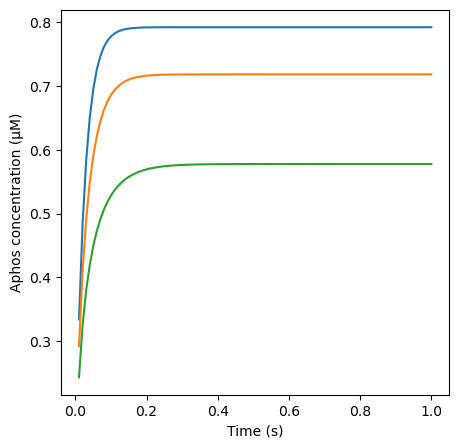

In [17]:
radiusVec = np.logspace(0,1,num=10) # currently testing 10 radius values
ss_vec = np.zeros(len(radiusVec))
ss_vec[0] = avg_Aphos[-1]
plt.plot(tvec, avg_Aphos)
plt.xlabel('Time (s)')
plt.ylabel('Aphos concentration (μM)')
for i in range(1,len(radiusVec)):
    curRadius = radiusVec[i]
    avg_Aphos = []
    tvec = []
    pc['VolSA'].value = curRadius/3

    # =============================================================================================
    # Create/load in mesh
    # =============================================================================================
    # Base mesh
    domain, facet_markers, cell_markers = common.DemoSpheresMesh(curRadius, 0, hEdge = 0.2) # 0 in second argument corresponds to no inner sphere
    # Write mesh and meshfunctions to file
    os.makedirs(f"mesh_{curRadius:03f}", exist_ok=True)
    common.write_mesh(domain, facet_markers, cell_markers, filename=f"mesh_{curRadius:03f}/DemoSphere")

    # # Define solvers
    parent_mesh = mesh.ParentMesh(
        mesh_filename=f"mesh_{curRadius:03f}/DemoSphere.h5",
        mesh_filetype="hdf5",
        name="parent_mesh",
    )
    configCur = config.Config()
    modelCur = model.Model(pc, sc, cc, rc, configCur, parent_mesh)
    configCur.solver.update(
        {
            "final_t": 1,
            "initial_dt": 0.01,
            "time_precision": 6,
            "use_snes": True,
            "print_assembly": False,
        }
    )

    modelCur.initialize(initialize_solver=False)
    modelCur.initialize_discrete_variational_problem_and_solver()
    # Write initial condition(s) to file
    results = dict()
    os.makedirs(f"resultsSphere_{curRadius:03f}", exist_ok=True)
    for species_name, species in modelCur.sc.items:
        results[species_name] = d.XDMFFile(
            modelCur.mpi_comm_world, f"resultsSphere_{curRadius:03f}/{species_name}.xdmf"
        )
        results[species_name].parameters["flush_output"] = True
        results[species_name].write(modelCur.sc[species_name].u["u"], modelCur.t)

    # Solve
    while True:
        # Solve the system
        modelCur.monolithic_solve()
        # Save results for post processing
        for species_name, species in modelCur.sc.items:
            results[species_name].write(modelCur.sc[species_name].u["u"], modelCur.t)
        # compute average Aphos concentration at each time step
        dx = d.Measure("dx",domain = modelCur.cc['Cyto'].dolfin_mesh)
        int_val = d.assemble(modelCur.sc['Aphos'].u['u']*dx)
        volume = d.assemble(1.0*dx)
        avg_Aphos.append(int_val / volume)
        tvec.append(modelCur.t)
        # End if we've passed the final time
        if modelCur.t >= modelCur.final_t:
            break
    
    # store steady state at the end of each run
    ss_vec[i] = avg_Aphos[-1]
    plt.plot(tvec, avg_Aphos)

np.savetxt(f"ss_vec.txt", ss_vec)

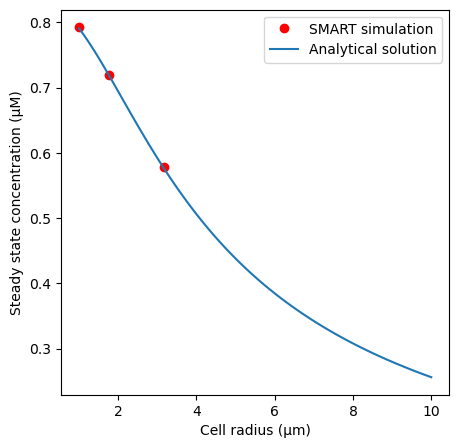

In [18]:
%matplotlib inline
plt.plot(radiusVec, ss_vec, 'ro')
radiusTest = np.logspace(0,1,100)
thieleMod = radiusTest / 1.0
k_kin = 50
k_p = 10
cT = 1
D = 10
C1 = k_kin*cT*radiusTest**2/((3*D*(np.sqrt(k_p/D)-(1/radiusTest)) + k_kin*radiusTest)*np.exp(thieleMod) +
        (3*D*(np.sqrt(k_p/D)+(1/radiusTest))-k_kin*radiusTest)*np.exp(-thieleMod))
cA = (6*C1/radiusTest)*(np.cosh(thieleMod)/thieleMod - np.sinh(thieleMod)/thieleMod**2)
plt.plot(radiusTest, cA)
plt.xlabel("Cell radius (μm)")
plt.ylabel("Steady state concentration (μM)")
plt.legend(("SMART simulation", "Analytical solution"))

RMSE with respect to analytical solution = 0.186%


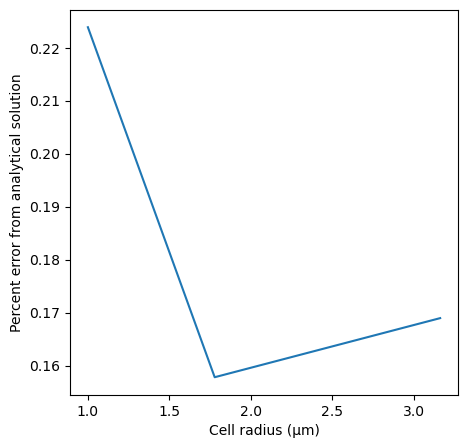

In [19]:
# quantify percent error
thieleMod = radiusVec / 1.0
k_kin = 50
k_p = 10
cT = 1
D = 10
C1 = k_kin*cT*radiusVec**2/((3*D*(np.sqrt(k_p/D)-(1/radiusVec)) + k_kin*radiusVec)*np.exp(thieleMod) +
        (3*D*(np.sqrt(k_p/D)+(1/radiusVec))-k_kin*radiusVec)*np.exp(-thieleMod))
cA = (6*C1/radiusVec)*(np.cosh(thieleMod)/thieleMod - np.sinh(thieleMod)/thieleMod**2)
percentError = 100*np.abs(ss_vec - cA) / cA
plt.plot(radiusVec,percentError)
plt.xlabel("Cell radius (μm)")
plt.ylabel("Percent error from analytical solution")
assert all(percentError < 1), f"Example 2 results deviate {max(percentError):.3f}% from the analytical solution"
rmse = np.sqrt(np.mean(percentError**2))
print(f"RMSE with respect to analytical solution = {rmse:.3f}%")

In [20]:
# check that solution is not too far from previous numerical solution (regression test)
ss_vec_ref = np.array([7.923821144851057596e-01, 7.669667883419870602e-01,
                       7.298498502029002744e-01, 6.788940529553533221e-01,
                       6.142454046569625348e-01, 5.396662231709322688e-01,
                       4.614726970070175405e-01, 3.858559025223168293e-01,
                       3.170657047898646219e-01, 2.570951001202800845e-01])
percentErrorRegression = 100*np.abs(ss_vec - ss_vec_ref) / ss_vec_ref
# not sure what the tolerated error should be for this regression test, currently set to 0.1%
assert all(percentErrorRegression < 0.1), f"Failed regression test: Example 2 results deviate {max(percentErrorRegression):.3f}% from the previous numerical solution"
rmse_regression = np.sqrt(np.mean(percentErrorRegression**2))
print(f"RMSE with respect to previous numerical solution = {rmse_regression:.3f}%")

ValueError: operands could not be broadcast together with shapes (3,) (10,) 